In [ ]:
%pip install pytorch-metric-learning
%pip install faiss-gpu

## Metric learning

The task of metric learning is to construct a function of two objects that will evaluate the distance (similarity) between them. By having such a function, we can perform object search, clustering, outlier detection, and so on. Next, we will consider the solution to this task using neural networks, a technique known as deep metric learning, which involves two main approaches:

- Siamese: A neural network takes two objects as input and returns the probability that they match or are similar (depending on the task formulation). This probability can be used as a measure of similarity or "distance."

- Representation learning: A neural network takes one object as input and returns a vector that represents this object in a certain vector space. Then, the classical distance between vectors is computed, for example, the Euclidean distance.

Suppose we need to evaluate all possible distances between objects. For the first approach, $O(n^2)$ model inferences are required, while for the second approach, $O(n)$ inferences and $O(n^2)$ distance calculations are needed. In practice, the second approach is more commonly used because calculating distances between vectors is much faster than inference. Going forward, we will only discuss this approach and perceive it as synonymous with metric learning.

Here is how the vector space of a model trained on the Fashion MNIST dataset looks like:

![](https://habrastorage.org/getpro/habr/upload_files/df3/68e/b0f/df368eb0f5746a4075f30e2cf8117e9a.gif)

**How does it differ from classification?**

The tasks of deep metric learning and classification can overlap, making the use of terminology confusing. On one hand, it is possible to train a classifier and then use the outputs from its last or penultimate layer as vectors on which distances are evaluated. On the other hand, a model can be trained with a non-classification loss function (e.g., triplet loss, which will be discussed later), but use the resulting vectors for classification by searching for nearest neighbors and taking the labels of their classes. Additionally, both tasks utilize the same network architectures.

Generally speaking, Deep Metric Learning is a group of techniques that aims to measure the similarity between data samples. More specifically, for a set of data points $X$ and their corresponding labels
$Y$ (a discrete finite set), the goal is to train an embedding neural model (also referred to as feature extractor) $f_{\theta}(\cdot)\, \colon \mathcal{X} \to \mathbb{R}^n$ (where $θ$ are learned weights) together with a distance
$\mathcal{D}\, \colon \mathbb{R}^n \to \mathbb{R}$
 (which is usually fixed beforehand), so that for two data samples
$x_1, x_2 \in \mathcal{X}$
 together with their labels $y_1, y_2 \in \mathcal{Y}$, the combination
$\mathcal{D}\left(f_{\theta}(x_1), f_{\theta}(x_2)\right)$ produces small values if the labels $y_1, y_2 \in \mathcal{Y}$ are equal, and larger values if they aren’t.



For further reading one can acknowledge with [great survey](https://hav4ik.github.io/articles/deep-metric-learning-survey)

### TripletMarginLoss on MNIST
*based on Pytorch Metric Learning [example](https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb)*

To learn better about triplet margin loss check this [tutorial](https://omoindrot.github.io/triplet-loss).

![](https://user-images.githubusercontent.com/18154355/61485418-1cbb1f00-a96f-11e9-8de8-3c46eef5a7dc.png)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1

### Training:

In [ ]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

In [24]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|██████████| 1875/1875 [00:20<00:00, 92.49it/s]


We compute metrics. It is logical to use metrics from information retrieval, for example:

- CMC@k - 1 if there is at least one correct answer in the top k results, otherwise 0.

- Precision@k - the proportion of correct answers in the top k results.

- MAP@k - similar to the previous metric, but it takes into account the positions of the correct answers.

### Visualization using T-SNE

Visualization is very important tool for analysis of your data. But we can't visualize a high dimensional space (how can we imagine 128-d space?). So, we have to lower dimension of your data and t-SNE is a solution



#### What is t-SNE?

Given a set of N high-dimensional objects
$\mathbf {x} _{1},\dots ,\mathbf {x} _{N}$, t-SNE first computes probabilities
$p_{ij}$ that are proportional to the similarity of objects

$\mathbf {x}_{i}$ and
$\mathbf {x}_{j}$, as follows.

For
$i\neq j$, define

$$
{\displaystyle p_{j\mid i}={\frac {\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}}}
$$
and set
${\displaystyle p_{i\mid i}=0}$. Note that
${\displaystyle \sum _{j}p_{j\mid i}=1}$ for all $i$

As Van der Maaten and Hinton explained: "The similarity of datapoint
$x_{j}$ to datapoint
$x_{i}$ is the conditional probability,
${\displaystyle p_{j|i}}$ that
$x_{i}$ would pick
$x_{j}$ as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at
$x_{i}$"

Now define

$${\displaystyle p_{ij}={\frac {p_{j\mid i}+p_{i\mid j}}{2N}}}$$

This is motivated because
$p_{i}$ and $p_{{j}}$ from the $N$ samples are estimated as $1/N$, so the conditional probability can be written as
${\displaystyle p_{i\mid j}=Np_{ij}}$ and
${\displaystyle p_{j\mid i}=Np_{ji}}$. Since
${\displaystyle p_{ij}=p_{ji}}$, you can obtain previous formula.

Also note that ${\displaystyle p_{ii}=0}$ and
${\displaystyle \sum _{i,j}p_{ij}=1}.$

The bandwidth of the Gaussian kernels
$\sigma _{i}$ is set in such a way that the entropy of the conditional distribution equals a predefined entropy using the bisection method. As a result, the bandwidth is adapted to the density of the data: smaller values of
$\sigma_{i}$ are used in denser parts of the data space.

Since the Gaussian kernel uses the Euclidean distance
${\displaystyle \lVert x_{i}-x_{j}\rVert }$, it is affected by the curse of dimensionality, and in high dimensional data when distances lose the ability to discriminate, the
$p_{ij}$ become too similar (asymptotically, they would converge to a constant). It has been proposed to adjust the distances with a power transform, based on the intrinsic dimension of each point, to alleviate this.

t-SNE aims to learn a $d$-dimensional map
$\mathbf {y} _{1},\dots ,\mathbf {y} _{N}$ (with
$\mathbf {y} _{i}\in \mathbb {R} ^{d}$ and
$d$ typically chosen as 2 or 3) that reflects the similarities
$p_{ij}$ as well as possible. To this end, it measures similarities
$q_{ij}$ between two points in the map
$\mathbf {y} _{i}$ and
$\mathbf {y} _{j}$, using a very similar approach. Specifically, for
$i\neq j$, define
$q_{ij}$ as

$${\displaystyle q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k}\sum _{l\neq k}(1+\lVert \mathbf {y} _{k}-\mathbf {y} _{l}\rVert ^{2})^{-1}}}}
$$
and set
${\displaystyle q_{ii}=0}$. Herein a heavy-tailed Student t-distribution (with one-degree of freedom, which is the same as a Cauchy distribution) is used to measure similarities between low-dimensional points in order to allow dissimilar objects to be modeled far apart in the map.

The locations of the points $\mathbf {y} _{i}$ in the map are determined by minimizing the (non-symmetric) Kullback–Leibler divergence of the distribution
$P$ from the distribution
$Q$, that is:

$${\displaystyle \mathrm {KL} \left(P\parallel Q\right)=\sum _{i\neq j}p_{ij}\log {\frac {p_{ij}}{q_{ij}}}}$$
The minimization of the Kullback–Leibler divergence with respect to the points $\mathbf {y} _{i}$ is performed using gradient descent. The result of this optimization is a map that reflects the similarities between the high-dimensional inputs.

T-SNE have big problems and
one can look [here for explanaition](https://distill.pub/2016/misread-tsne/).


### T-SNE implementation

Let's use TSNE from `sklearn` package

In [26]:
feats = train_embeddings.cpu().numpy()[:1000]
y_subset = train_labels.cpu().numpy()[:1000]

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7909a1e96e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.178737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.408085
[t-SNE] KL divergence after 1000 iterations: 0.330592


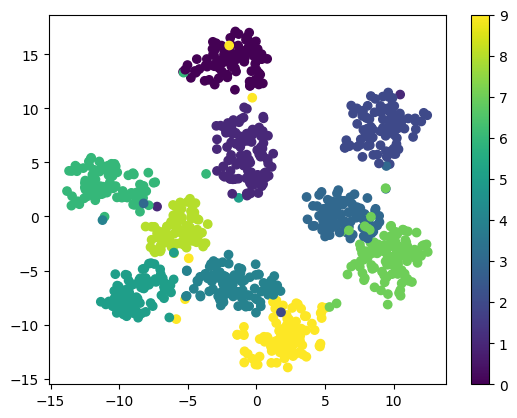

In [27]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE


tSNE_metrics = TSNE(n_components=3, random_state=0, verbose=True).fit_transform(feats)
plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=y_subset)
plt.colorbar()
plt.savefig('tsne_classification.png')
plt.show()

Let's visualize it even better with `plotly` package

In [20]:
import plotly.graph_objects as go

x=tSNE_metrics[:, 0]
y=tSNE_metrics[:, 1]
z=tSNE_metrics[:, 2]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=y_subset,                # set color to an array/list of desired values
        colorscale='Spectral',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### Let's see how it works on pretrained classifier model

In [30]:
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm_notebook

model_urls = {
    'mnist': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth'
}

In [31]:
class MLP(nn.Module):
    def __init__(self, input_dims, n_hiddens, n_class):
        super(MLP, self).__init__()
        assert isinstance(input_dims, int), 'Please provide int for input_dims'
        self.input_dims = input_dims
        current_dims = input_dims
        layers = OrderedDict()

        if isinstance(n_hiddens, int):
            n_hiddens = [n_hiddens]
        else:
            n_hiddens = list(n_hiddens)
        for i, n_hidden in enumerate(n_hiddens):
            layers['fc{}'.format(i+1)] = nn.Linear(current_dims, n_hidden)
            layers['relu{}'.format(i+1)] = nn.ReLU()
            layers['drop{}'.format(i+1)] = nn.Dropout(0.2)
            current_dims = n_hidden
        layers['out'] = nn.Linear(current_dims, n_class)

        self.model= nn.Sequential(layers)
        print(self.model)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

In [32]:
def mnist(input_dims=784, n_hiddens=[256, 256], n_class=10, pretrained=None):
    model = MLP(input_dims, n_hiddens, n_class)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['mnist'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

In [33]:
model = mnist(pretrained=True)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
import torch
import torch.nn as nn

from collections import OrderedDict

from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='.', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=128, shuffle=True)

train_embeddings = []
train_labels = []

with torch.no_grad():
    model.eval()
    for (x, y) in tqdm_notebook(train_loader):
        train_embeddings += [model(x)]
        train_labels += [y]

In [ ]:
import numpy as np

feats = train_embeddings.cpu().numpy()[:1000]
y_subset = train_labels.cpu().numpy()[:1000]

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE


tSNE_metrics = TSNE(n_components=3, random_state=0, verbose=True).fit_transform(feats)
plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=y_subset)
plt.colorbar()
plt.savefig('tsne_classification.png')
plt.show()